In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.__version__

'2.9.0'

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir="fer2013plus/fer2013/train/"
test_dir="fer2013plus/fer2013/test/"


train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=128,
                                               target_size=(48,48),
                                               class_mode="categorical",
                                               seed=42)
test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=128,
                                             target_size=(48,48),
                                             class_mode="categorical",
                                             seed=42)

Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [3]:
#Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    
    min_delta=0.0001,      
    patience=4,            
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  #val_loss no overfitting   
    min_delta=0.0001,  
    mode="min",
    factor=0.5,                 
    patience=4,                 
    min_lr=1e-7,                
    verbose=1                   
)

# checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", monitor='val_accuracy', 
#                          verbose=1, save_best_only=True, mode='max')

In [4]:
# VGG 19
# 1. Create a base model with tf.keras.applciations
base_model1 = tf.keras.applications.VGG16(include_top=False, input_shape=(48,48,3)) # include_top -> last layer (will be different for different datasets)
base_model2 = tf.keras.applications.VGG19(include_top=False, input_shape=(48,48,3))
# 2. Freeze the base model, underlying pre-trained weights arent updated during training
base_model1.trainable=False
base_model2.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(48,48,3),
                               name="input_layer")

# 4. (Optional) -> if using resnet -> need to normalize inputs -> not needed for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x1 = base_model1(inputs)
x2 = base_model2(inputs)

# print("shape after passing inputs through base_model: "+str(x.shape))

# 6. Average pool the outputs of the base_model (aggregate all most of information, reduce number of computations)
x1 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x1)
x2 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x2)

# print("Shape after GlobalAveragePooling2D: "+str(x.shape))

# 7. Create the output activation layer
outputs1 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x1)
outputs2 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x2)

# 8. Combine input with the outputs into a model
model_vgg16 = tf.keras.Model(inputs,outputs1)
model_vgg19 = tf.keras.Model(inputs,outputs2)

# 9. Compile the model
model_vgg16.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_vgg16 = model_vgg16.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[lr_scheduler,early_stopping])


# 9. Compile the model
model_vgg19.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_vgg19 = model_vgg19.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[lr_scheduler,early_stopping])

Epoch 1/100
222/222 [==============================] - 14s 55ms/step - loss: 1.4891 - accuracy: 0.4200 - val_loss: 1.4084 - val_accuracy: 0.4656 - lr: 0.0010
Epoch 2/100
222/222 [==============================] - 11s 49ms/step - loss: 1.3653 - accuracy: 0.4844 - val_loss: 1.3651 - val_accuracy: 0.4936 - lr: 0.0010
Epoch 3/100
222/222 [==============================] - 11s 49ms/step - loss: 1.3279 - accuracy: 0.5016 - val_loss: 1.3416 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 4/100
222/222 [==============================] - 11s 49ms/step - loss: 1.3050 - accuracy: 0.5093 - val_loss: 1.3214 - val_accuracy: 0.5049 - lr: 0.0010
Epoch 5/100
221/222 [============================>.] - ETA: 0s - loss: 1.2892 - accuracy: 0.5156
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
222/222 [==============================] - 11s 49ms/step - loss: 1.2887 - accuracy: 0.5159 - val_loss: 1.3106 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 6/100
222/222 [============================

In [5]:
# VGG 19
# 1. Create a base model with tf.keras.applciations
base_model1 = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(48,48,3)) # include_top -> last layer (will be different for different datasets)
# base_model2 = tf.keras.applications.VGG19(include_top=False, input_shape=(48,48,3))
# 2. Freeze the base model, underlying pre-trained weights arent updated during training
base_model1.trainable=False
# base_model2.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(48,48,3),
                               name="input_layer")

# 4. (Optional) -> if using resnet -> need to normalize inputs -> not needed for EfficientNet
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x1 = base_model1(inputs)

# print("shape after passing inputs through base_model: "+str(x.shape))

# 6. Average pool the outputs of the base_model (aggregate all most of information, reduce number of computations)
x1 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x1)
# x2 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x2)

# print("Shape after GlobalAveragePooling2D: "+str(x.shape))

# 7. Create the output activation layer
outputs1 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x1)
# outputs2 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x2)

# 8. Combine input with the outputs into a model
model_resnet = tf.keras.Model(inputs,outputs1)
# model_vgg19 = tf.keras.Model(inputs,outputs2)

# 9. Compile the model
model_resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_resnet = model_resnet.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[lr_scheduler,early_stopping])


Epoch 1/100
222/222 [==============================] - 13s 46ms/step - loss: 1.6438 - accuracy: 0.4193 - val_loss: 1.4282 - val_accuracy: 0.4694 - lr: 0.0010
Epoch 2/100
222/222 [==============================] - 8s 36ms/step - loss: 1.3337 - accuracy: 0.5034 - val_loss: 1.3854 - val_accuracy: 0.4909 - lr: 0.0010
Epoch 3/100
222/222 [==============================] - 8s 36ms/step - loss: 1.2604 - accuracy: 0.5240 - val_loss: 1.3609 - val_accuracy: 0.5030 - lr: 0.0010
Epoch 4/100
222/222 [==============================] - 8s 36ms/step - loss: 1.2176 - accuracy: 0.5419 - val_loss: 1.3441 - val_accuracy: 0.5081 - lr: 0.0010
Epoch 5/100
221/222 [============================>.] - ETA: 0s - loss: 1.1805 - accuracy: 0.5576
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
222/222 [==============================] - 8s 36ms/step - loss: 1.1810 - accuracy: 0.5574 - val_loss: 1.3372 - val_accuracy: 0.5189 - lr: 0.0010
Epoch 6/100
222/222 [==============================] 

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir="fer2013plus/fer2013/train/"
test_dir="fer2013plus/fer2013/test/"


train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=128,
                                               target_size=(48,48),
                                               class_mode="categorical",
                                               seed=42)
test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size=128,
                                             target_size=(48,48),
                                             class_mode="categorical",
                                             seed=42)


# 1. Create a base model with tf.keras.applciations
base_model1 = tf.keras.applications.EfficientNetB4(include_top=False, input_shape=(48,48,3)) # include_top -> last layer (will be different for different datasets)
# base_model2 = tf.keras.applications.VGG19(include_top=False, input_shape=(48,48,3))
# 2. Freeze the base model, underlying pre-trained weights arent updated during training
base_model1.trainable=False
# base_model2.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(48,48,3),
                               name="input_layer")

# 4. (Optional) -> if using resnet -> need to normalize inputs -> not needed for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x1 = base_model1(inputs)

# print("shape after passing inputs through base_model: "+str(x.shape))

# 6. Average pool the outputs of the base_model (aggregate all most of information, reduce number of computations)
x1 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x1)
# x2 = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x2)

# print("Shape after GlobalAveragePooling2D: "+str(x.shape))

# 7. Create the output activation layer
outputs1 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x1)
# outputs2 = tf.keras.layers.Dense(8,activation=tf.keras.activations.softmax,name="output_layers")(x2)

# 8. Combine input with the outputs into a model
model_eff_4 = tf.keras.Model(inputs,outputs1)
# model_vgg19 = tf.keras.Model(inputs,outputs2)

# 9. Compile the model
model_eff_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_eff_4 = model_eff_4.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[lr_scheduler,early_stopping])


Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.
Epoch 1/100
222/222 [==============================] - 29s 101ms/step - loss: 1.6255 - accuracy: 0.3469 - val_loss: 1.6427 - val_accuracy: 0.3658 - lr: 0.0010
Epoch 2/100
222/222 [==============================] - 19s 86ms/step - loss: 1.6120 - accuracy: 0.3506 - val_loss: 1.6412 - val_accuracy: 0.2798 - lr: 0.0010
Epoch 3/100
222/222 [==============================] - 19s 86ms/step - loss: 1.6127 - accuracy: 0.3517 - val_loss: 1.6166 - val_accuracy: 0.3658 - lr: 0.0010
Epoch 4/100
222/222 [==============================] - 19s 86ms/step - loss: 1.6120 - accuracy: 0.3577 - val_loss: 1.6230 - val_accuracy: 0.2714 - lr: 0.0010
Epoch 5/100
222/222 [==============================] - 19s 86ms/step - loss: 1.6137 - accuracy: 0.3532 - val_loss: 1.6550 - val_accuracy: 0.2574 - lr: 0.0010
Epoch 6/100
222/222 [==============================] - 19s 86ms/step - loss: 1.6131 - accuracy: 0.3497 - val_loss: 1.6087 - 

In [7]:
model_eff_4.layers[1].name

'efficientnetb4'

In [8]:
history_eff_4.history

{'loss': [1.6255351305007935,
  1.61203134059906,
  1.6126787662506104,
  1.6119500398635864,
  1.6137162446975708,
  1.6131075620651245,
  1.6158254146575928,
  1.6104484796524048,
  1.6094534397125244,
  1.604360818862915,
  1.6039527654647827,
  1.6018317937850952,
  1.6019314527511597,
  1.599887728691101],
 'accuracy': [0.3468611240386963,
  0.35056012868881226,
  0.3516874611377716,
  0.35774677991867065,
  0.35320228338241577,
  0.34971463680267334,
  0.35344889760017395,
  0.35235679149627686,
  0.35292044281959534,
  0.359508216381073,
  0.36000141501426697,
  0.36292538046836853,
  0.36112871766090393,
  0.3598252534866333],
 'val_loss': [1.6426810026168823,
  1.6412400007247925,
  1.616636872291565,
  1.6229945421218872,
  1.6549503803253174,
  1.6087408065795898,
  1.6113201379776,
  1.6370898485183716,
  1.6235766410827637,
  1.6081123352050781,
  1.6128703355789185,
  1.6082179546356201,
  1.61514151096344,
  1.609356164932251],
 'val_accuracy': [0.36582615971565247,
  0.

In [9]:
model_names=["vgg16","vgg19","effnetb4","resnet"]

In [10]:
filename=["historyvgg16","historyvgg19","historyresnet","historyeffnetb4"]

In [11]:
vars1=[history_vgg16,history_vgg19,history_resnet, history_eff_4]

In [14]:
import pickle
def store_variables(filename=[],vars1=[]):
    if len(filename)==len(vars1):
        for i in range(len(vars1)):
            with open(f"history_var/{filename[i]}", 'wb') as file:
                pickle.dump(vars1[i], file)
store_variables(filename,vars1)

INFO:tensorflow:Assets written to: ram://c07e7da4-59bf-4df5-8d9c-2d6939029562/assets


INFO:tensorflow:Assets written to: ram://c07e7da4-59bf-4df5-8d9c-2d6939029562/assets


INFO:tensorflow:Assets written to: ram://f3fa8a35-aaac-452e-8b7b-7c54c6332e8f/assets


INFO:tensorflow:Assets written to: ram://f3fa8a35-aaac-452e-8b7b-7c54c6332e8f/assets


INFO:tensorflow:Assets written to: ram://b213bcc0-d884-41fa-bf7a-499ef018b953/assets


INFO:tensorflow:Assets written to: ram://b213bcc0-d884-41fa-bf7a-499ef018b953/assets


INFO:tensorflow:Assets written to: ram://004b58b5-47fb-435d-9ac0-f1ca5f2382c9/assets


INFO:tensorflow:Assets written to: ram://004b58b5-47fb-435d-9ac0-f1ca5f2382c9/assets


In [2]:
filename=["historyvgg16","historyvgg19","historyresnet","historyeffnetb4","hist_dcnn.pkl"]

In [3]:
import pickle
vars2=[]
def load_variables(filename=[],vars2=[]):
    for i in range(len(filename)):
        with open(f'history_var/{filename[i]}', 'rb') as file:
            vars2.append(pickle.load(file))
load_variables(filename,vars2)

2023-08-15 17:41:16.158187: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-15 17:41:17.694750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 17:41:17.759971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 17:41:17.760118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 17:41:17.760685: I tensorflow/core/

In [4]:
vars2

<AxesSubplot: >

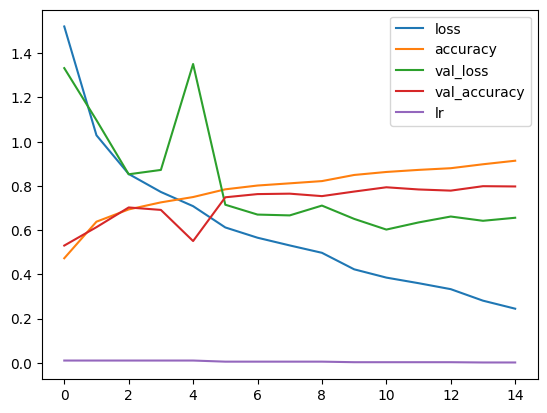

In [13]:
import pandas as pd

pd.DataFrame(vars2[4].history).plot()

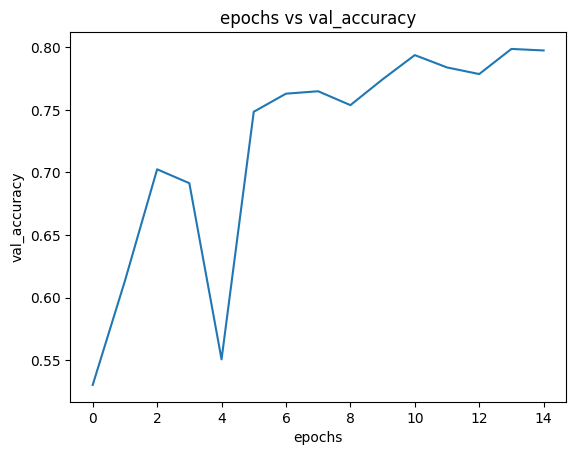

In [28]:
import matplotlib.pyplot as plt
plt.plot(vars2[4].history["val_accuracy"])
plt.title("epochs vs val_accuracy")
plt.xlabel("epochs")
plt.ylabel("val_accuracy")
plt.savefig("plot_model/val_accuracy-dcnn")

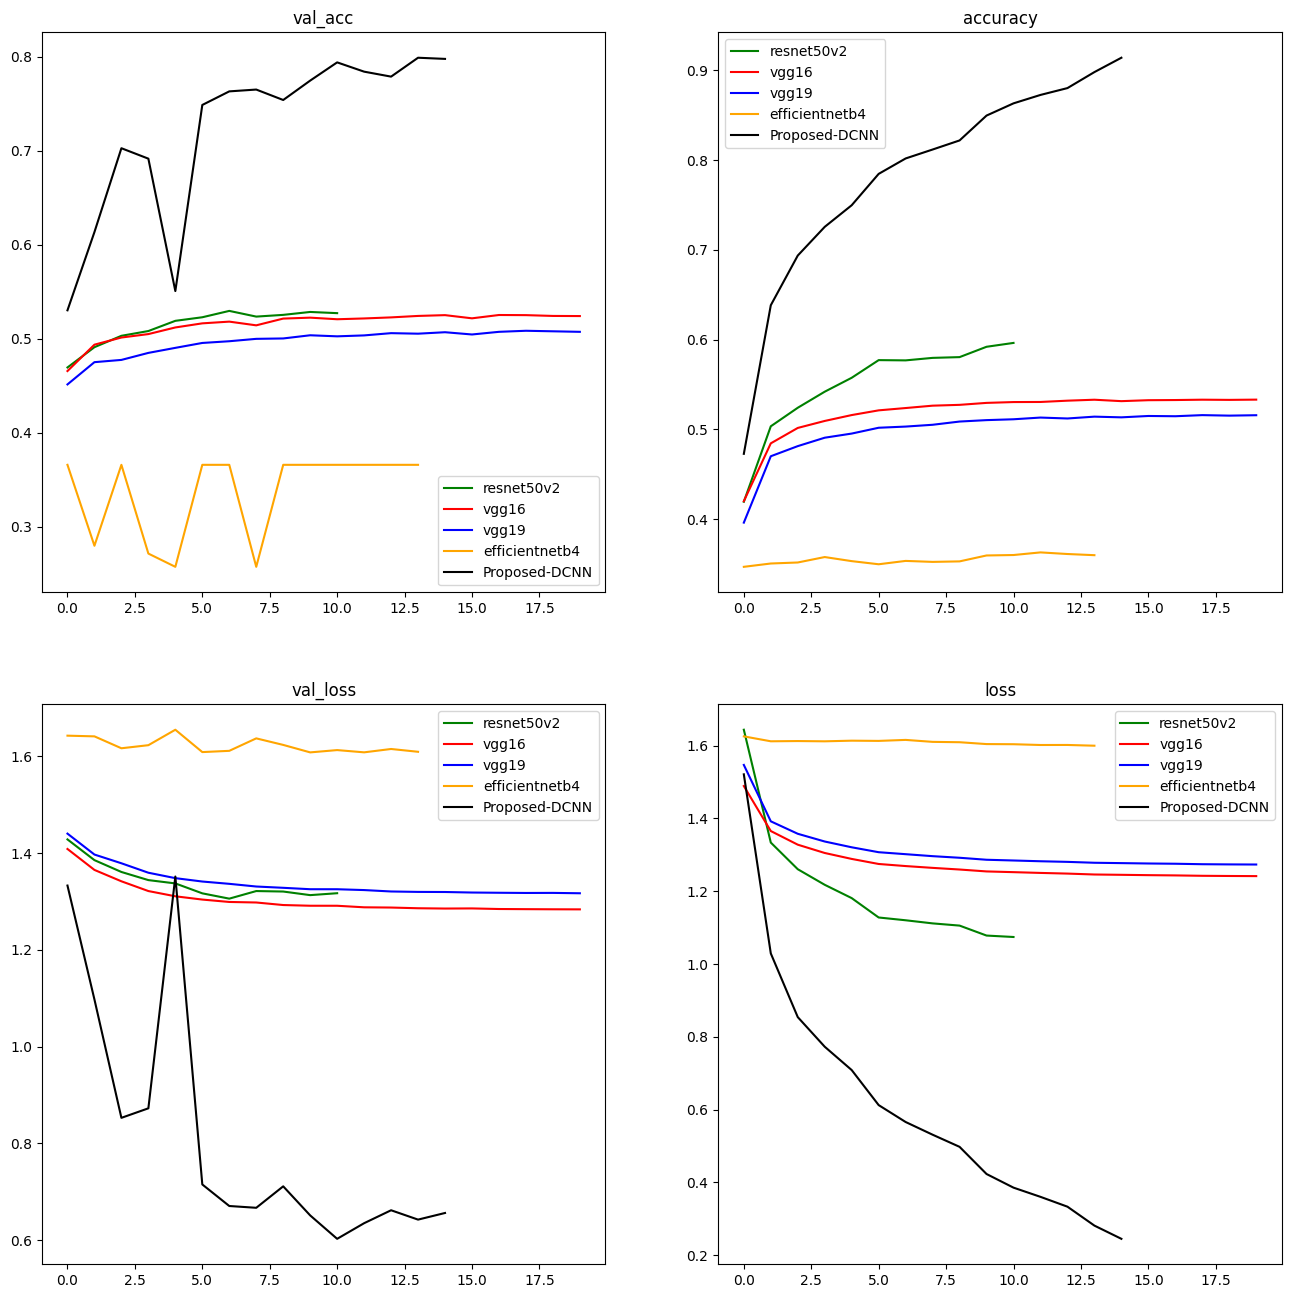

In [28]:
import matplotlib.pyplot as plt
def plot_hi(hist=[],model=[]):
    val_acc=[]
    val_loss=[]
    loss=[]
    accuracy=[]
    metrics=[val_acc,accuracy,val_loss,loss]
    metrics_title=["val_acc","accuracy","val_loss","loss"]
    for history in hist:
        accuracy.append(history.history["accuracy"][:20])
        val_acc.append(history.history["val_accuracy"][:20])
        loss.append(history.history["loss"][:20])
        val_loss.append(history.history["val_loss"][:20])
    
    plt.figure(figsize=(16,16))
    c=['g','r','b','orange',"black"]
    for j in range(len(metrics)):
        plt.subplot(2,2,j+1)
        for i in range(len(hist)):
            plt.plot(metrics[j][i],c=c[i],label=model[i])
        plt.title(metrics_title[j])
        plt.legend()
        
    plt.savefig(f"plot_model/full")
    plt.show()
plot_hi([history_resnet,
         history_vgg16,
         history_vgg19,
         history_eff_4,
         history_dcnn],

        [model_resnet.layers[1].name,
         model_vgg16.layers[1].name,
         model_vgg19.layers[1].name,
         model_eff_4.layers[1].name,
         "Proposed-DCNN",])

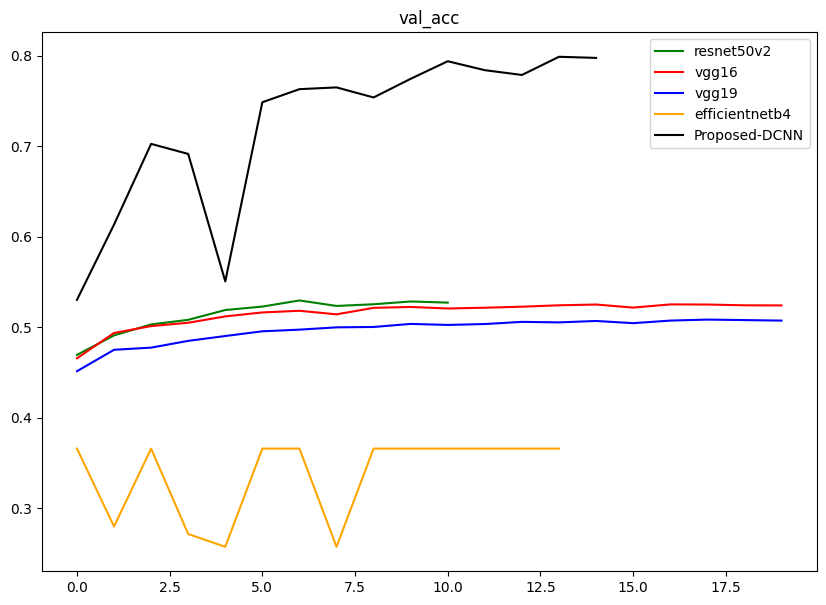

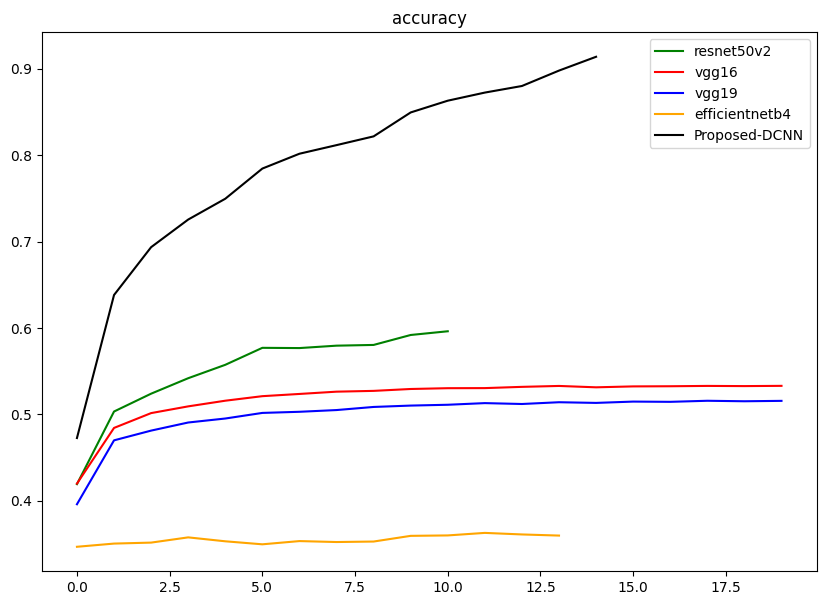

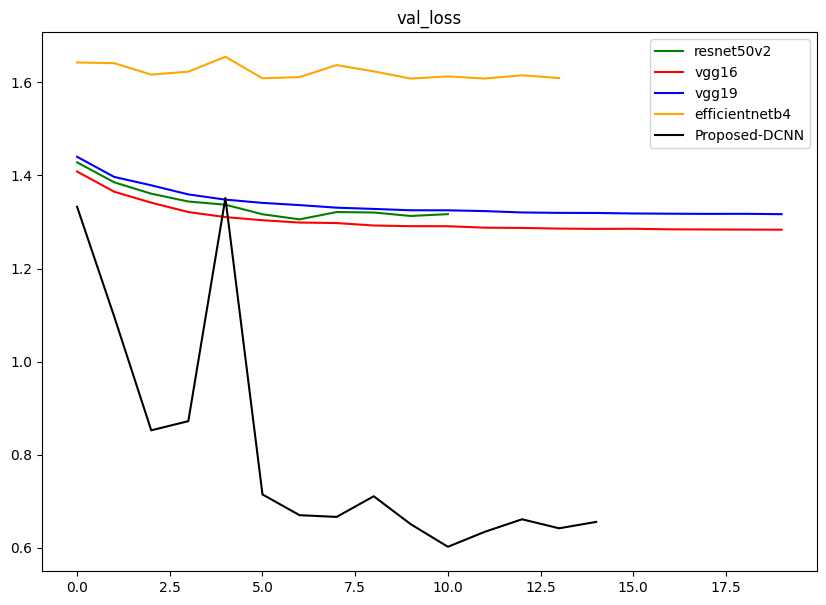

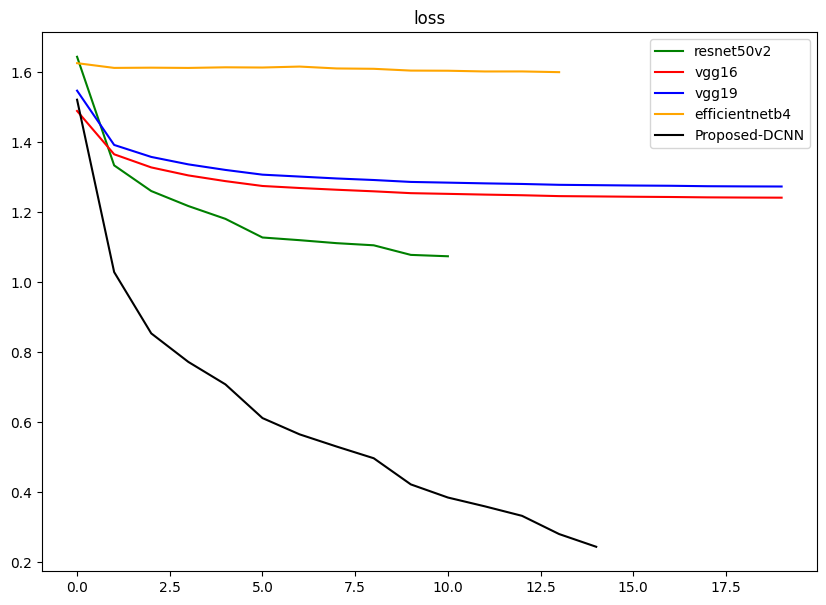

In [27]:
import matplotlib.pyplot as plt
def plot_hi(hist=[],model=[]):
    val_acc=[]
    val_loss=[]
    loss=[]
    accuracy=[]
    metrics=[val_acc,accuracy,val_loss,loss]
    metrics_title=["val_acc","accuracy","val_loss","loss"]
    for history in hist:
        accuracy.append(history.history["accuracy"][:20])
        val_acc.append(history.history["val_accuracy"][:20])
        loss.append(history.history["loss"][:20])
        val_loss.append(history.history["val_loss"][:20])
    
    # plt.figure(figsize=(16,16))
    c=['g','r','b','orange',"black"]
    for j in range(len(metrics)):
        # plt.subplot(2,2,j+1)
        plt.figure(figsize=(10,7))
        for i in range(len(hist)):
            plt.plot(metrics[j][i],c=c[i],label=model[i])
        plt.title(metrics_title[j])
        plt.legend()
        plt.savefig(f"plot_model/{metrics_title[j]}")

    plt.show()
plot_hi([history_resnet,
         history_vgg16,
         history_vgg19,
         history_eff_4,
         history_dcnn],

        [model_resnet.layers[1].name,
         model_vgg16.layers[1].name,
         model_vgg19.layers[1].name,
         model_eff_4.layers[1].name,
         "Proposed-DCNN",])

In [29]:
y_pred_vgg16 = model_vgg19.predict(test_data)
y_pred_vgg19 = model_vgg19.predict(test_data)
y_pred_resnet = model_resnet.predict(test_data)
y_pred_effnetb4 = model_eff_4.predict(test_data)

 1/56 [..............................] - ETA: 2s

56/56 [==============================] - 4s 63ms/step


In [30]:
y_pred_vgg16 = tf.argmax(y_pred_vgg16,axis=1)
y_pred_vgg19 = tf.argmax(y_pred_vgg19,axis=1)
y_pred_resnet = tf.argmax(y_pred_resnet,axis=1)
y_pred_effnetb4 = tf.argmax(y_pred_effnetb4,axis=1)

In [26]:
from helper_functions import calculate_results
print("vgg16",calculate_results(test_data.labels,y_pred_vgg16.numpy()))
print(calculate_results(test_data.labels,y_pred_vgg19.numpy()))
print(calculate_results(test_data.labels,y_pred_resnet.numpy()))
print(calculate_results(test_data.labels,y_pred_effnetb4.numpy()))

{'accuracy': 28.257501056486827, 'precision': 0.2290343208438146, 'recall': 0.28257501056486833, 'f1': 0.24719325042904855}
{'accuracy': 29.48302577827863, 'precision': 0.24518252371213622, 'recall': 0.2948302577827863, 'f1': 0.26001958053808644}
{'accuracy': 27.00380335258487, 'precision': 0.24050591370291752, 'recall': 0.2700380335258487, 'f1': 0.2520829492907257}
{'accuracy': 36.58261727003803, 'precision': 0.1338287886326085, 'recall': 0.3658261727003803, 'f1': 0.19596752691891248}


/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
model_dcnn = tf.keras.models.load_model("high")
model_dcnn.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0      

In [32]:
calculate_results(test_data.labels, tf.argmax(model_dcnn.predict(test_data),axis=1).numpy())

NotFoundError: Graph execution error:

Detected at node 'DCNN/conv2d_1/Conv2D' defined at (most recent call last):
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_149414/1780590433.py", line 1, in <module>
      calculate_results(test_data.labels, tf.argmax(model_dcnn.predict(test_data),axis=1).numpy())
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/ujjwal/miniconda3/envs/TF/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'DCNN/conv2d_1/Conv2D'
No algorithm worked!  Error messages:
	 [[{{node DCNN/conv2d_1/Conv2D}}]] [Op:__inference_predict_function_189049]